# <font color=green>Effects Quantification</font> 

**Author: Ruoou Yang**

In this tutorial, we will plot the seasonal near-surface temperature climatatology in China for 2015-2100 under the ssp126 scenario.
## <font color=green> Method A
We need to take the China map seriously because it refers to China territory. This tutorial gives two options for drawing a map of China. First is the easiest way, using the python package **cnmaps**. Document can be found on: https://cnmaps-doc.readthedocs.io/zh_CN/latest/index.html (currently only in Chinese)
    
### <font color=green>1 Download pakage

In [ ]:
!pip install cnmaps==1.0.1

### <font color=green>2 Import pakages

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
import cftime
from cftime import DatetimeNoLeap

# import cnmaps pakage
from cnmaps import get_adm_maps, draw_map, draw_maps

In [2]:
# make a list of all the models
models_list = ['BCC', 'MPI', 'EC', 'CanESM5', 'CNRM', 'CESM2', 'UKESM1', 'MIROC', 'IPSL']

### <font color=green>3 Make Plots
We began graphing and plotting the seasonal near-surface temperature climatology in China for 2015-2100. A number of commands need to be highlighted in this process:
    
+ `dset.sel(time=slice("2015-01-16", "2100-12-16"))`Intercepted data from 2015-01-16 to 2100-12-16 segment
    
+ `clim_set_t['tas'].groupby('time.season').mean('time', keep_attrs=True)`Average data for seasons, which can be replaced with months

+ `xarray.plot.contourf(col = 'season', col_wrap = 4)`**Faceting** here refers to plot 4 seasons climatology in a row, which provides a easier way to plot groups of pictures. More information is on https://xarray.pydata.org/en/stable/user-guide/plotting.html#faceting.

<Figure size 720x576 with 0 Axes>

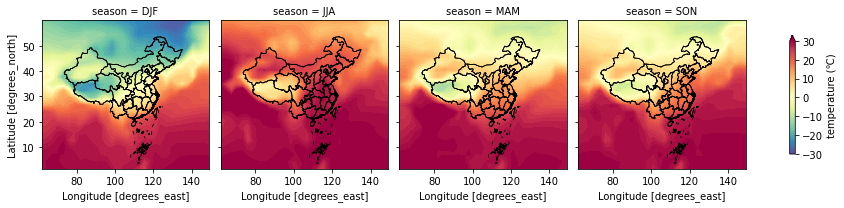

<Figure size 720x576 with 0 Axes>

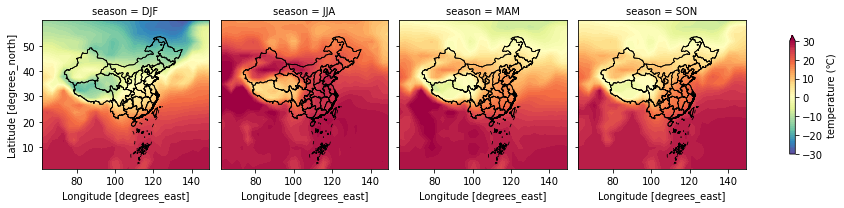

<Figure size 720x576 with 0 Axes>

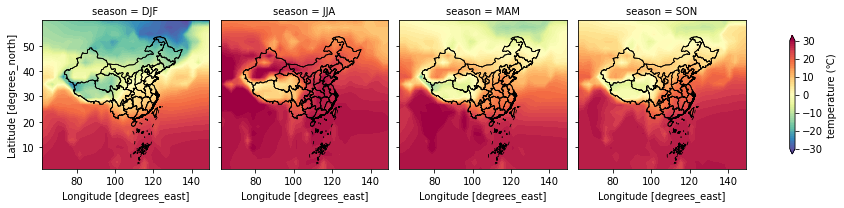

<Figure size 720x576 with 0 Axes>

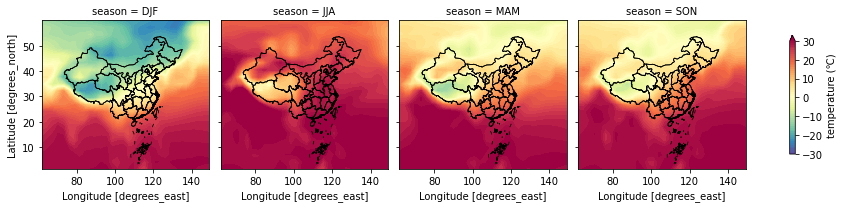

<Figure size 720x576 with 0 Axes>

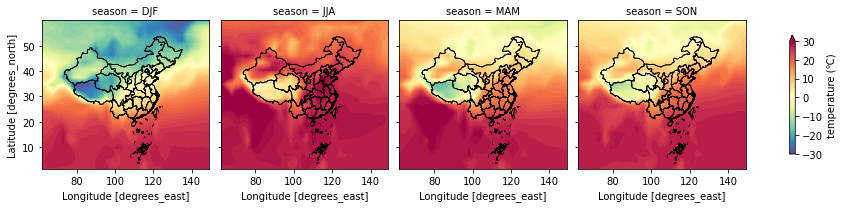

<Figure size 720x576 with 0 Axes>

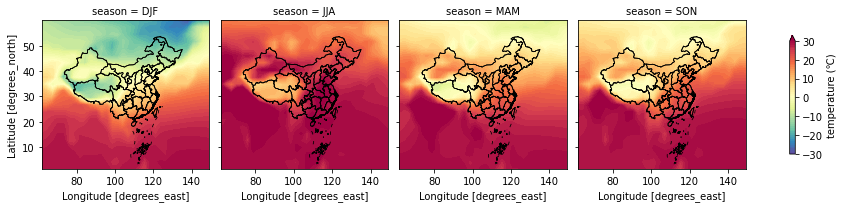

<Figure size 720x576 with 0 Axes>

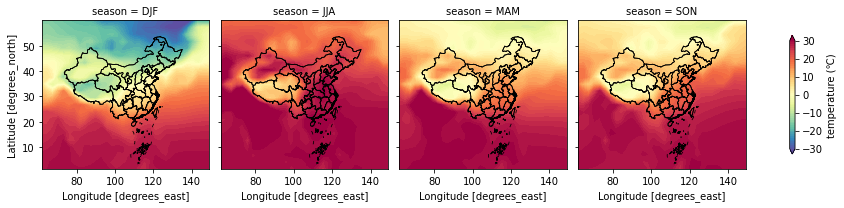

<Figure size 720x576 with 0 Axes>

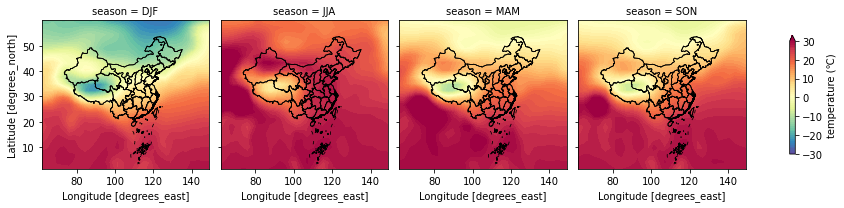

<Figure size 720x576 with 0 Axes>

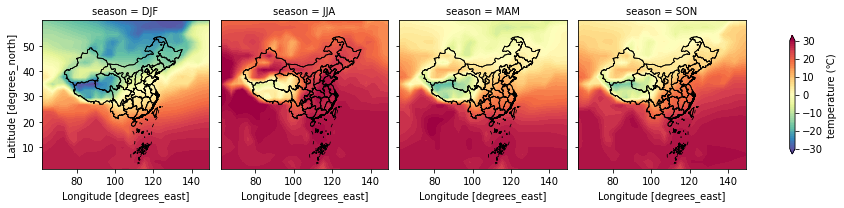

In [4]:
# use loop to read 9 remapped model data (described in Data Process tutorial)
for mod in models_list:
    dset = xr.open_dataset('/home/users/ruoou/projects/data/cmip6/scenaromip/ssp126/tas_single/' + mod + '_remap.nc')
    
    # define time
    time = dset.time
    # define timescale
    clim_set_t = dset.sel(time=slice("2015-01-16", "2100-12-16"))
    # average data for seasons
    clim_ta = clim_set_t['tas'].groupby('time.season').mean('time', keep_attrs=True)
    # convert units from K to ℃
    clim_ta_c = (clim_ta - 273.15)
    
    # define areas
    lat = dset.lat
    lon = dset.lon
    lon_range = lon[(lon>60) & (lon<150)]
    lat_range = lat[(lat>0) & (lat<60)]
    
    # create faceted plots
    fig = clim_ta_c.sel(lon=lon_range, lat=lat_range).plot.contourf(col = 'season', col_wrap = 4,
                                          levels=np.arange(-30, 30 + 1, 1),
                                          cmap='Spectral_r',
                                          cbar_kwargs={'orientation': 'vertical',     #colorbar
                                                   'label': 'temperature (℃)',
                                                   'ticks': np.arange(-30, 30 + 5, 10),
                                                   'pad': 0.05,
                                                   'shrink': 0.8});

    
    # add China country (国) boundary and defne line feature
    fig.map(lambda:draw_maps(get_adm_maps(level= '国'), linewidth=0.8, color='k'));
    # add China provice (省) boundary
    fig.map(lambda:draw_maps(get_adm_maps(level= '省'), linewidth=0.8, color='k'));    

## <font color=green> Method B
The second method will use the Lambert projection to present the South China Sea section as a subplot. This  method is more common, but  more complex than the previous one. Reference: https://blog.csdn.net/weixin_42372313/article/details/113665724?spm=1001.2101.3001.6661.1&utm_medium=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1.pc_relevant_aa&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-2%7Edefault%7ECTRLIST%7Edefault-1.pc_relevant_aa&utm_relevant_index=1
    
### <font color=green>1 Import pakages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from copy import copy
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
import netCDF4
from netCDF4 import Dataset
import cftime
from cftime import DatetimeNoLeap

### <font color=green>2 Define function
Functions used to draw the coordinate axis scales (latitude and longitude scales, with latitude being the Y-axis and longitude being the X-axis.)

In [3]:
def find_side(ls, side):
    """Given a shapely LineString which is assumed to be rectangular, return theline corresponding to a given side of the rectangle."""
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])
def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible: 
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

### <font color=green>3 Load the border data
CN-border-La.dat is downloaded from https://gmt-china.org/data/CN-border-La.dat

In [4]:
# Load the border data
with open('/home/users/ruoou/projects/data/Map/CN-border-La.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]


### <font color=green>4 Define Plotting function
Define a function that, when inputting a data file, a season, will give you the specified graph.

In [5]:
def plot_ta_climatology(ta_file, season, gridlines=False):

    """Plot the temperature climatology.
    
    Args:
      ta_file (str): Air-temperature data file
      season (str): Season (3 letter abbreviation, e.g. JJA)
      gridlines (bool): Select whether to plot gridlines
    
    """
    
    # Set figure size
    proj = ccrs.LambertConformal(central_longitude=105, central_latitude=90,
                                 false_easting=400000, false_northing=400000)#,standard_parallels=(46, 49))

    fig = plt.figure(figsize=[10, 8],frameon=True)


    # Set projection and plot the main figure
    ax = fig.add_axes([0.08, 0.05, 0.8, 0.94], projection=proj)
    # Set figure extent
    ax.set_extent([80, 130, 15, 55],crs=ccrs.PlateCarree())

    # Plot border lines
    for line in borders:
        ax.plot(line[0::2], line[1::2], '-', lw=1.0, color='k',
                transform=ccrs.Geodetic())

    # Add ocean, land, rivers and lakes
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), lw = 0.5)
    ax.add_feature(cfeature.LAND.with_scale('50m'), lw = 0.5)
    ax.add_feature(cfeature.RIVERS.with_scale('50m'), lw = 0.5)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), lw = 0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw = 0.5, edgecolor='gray')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw = 0.5, edgecolor='gray')


    # *must* call draw in order to get the axis boundary used to add ticks:
    fig.canvas.draw()

    # Define gridline locations and draw the lines using cartopy's built-in gridliner:
    xticks = [55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165]
    yticks = [0 , 5 , 10, 15, 20, 25 , 30 , 35 , 40 , 45 , 50 , 55 , 60 , 65]
    ax.gridlines(xlocs=xticks, ylocs=yticks, linestyle='--', lw=1 ,color='dimgrey')

    # Label the end-points of the gridlines using the custom tick makers:
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    lambert_xticks(ax, xticks)
    lambert_yticks(ax, yticks)

    #read multiple data
    dset = xr.open_mfdataset(ta_file, parallel=True)
    
    #define time
    time = dset.time
    clim_set_t = dset.sel(time=slice("2015-01-16", "2100-12-16"))
    clim_ta = clim_set_t['tas'].groupby('time.season').mean('time', keep_attrs=True)
    clim_ta_c = (clim_ta - 273.15)
    
    # define areas
    lat = dset.lat
    lon = dset.lon
    lon_range = lon[(lon>60) & (lon<150)]
    lat_range = lat[(lat>10) & (lat<60)]
    
    
    clim_ta_c.sel(lon=lon_range, lat=lat_range, season = season).plot.contourf(ax=ax,
                                          levels=np.arange(-30, 30 + 1, 1),
                                          transform=ccrs.PlateCarree(),
                                          cmap='Spectral_r',
                                          cbar_kwargs={'orientation': 'vertical',     #colorbar
                                                   'label': 'temperature (℃)',
                                                   'ticks': np.arange(-30, 30 + 5, 5),
                                                   'pad': 0.05,
                                                   'shrink': 0.8})
    #add title                      
    model = dset.attrs['source_id']
    title = f'{model} near-surface temperature climatology 2015-2100 ({season})'
    plt.title(title, fontsize = 13)
    
    #Plot South China Sea as a subfigure
    sub_ax = fig.add_axes([0.592, 0.189, 0.14, 0.155],
                          projection=ccrs.LambertConformal(central_latitude=90,
                                                           central_longitude=115))

    # Add ocean, land, rivers and lakes
    sub_ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    sub_ax.add_feature(cfeature.LAND.with_scale('50m'))
    sub_ax.add_feature(cfeature.RIVERS.with_scale('50m'))
    sub_ax.add_feature(cfeature.LAKES.with_scale('50m'))
    sub_ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw = 0.5, edgecolor='gray')
    sub_ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw = 0.5, edgecolor='gray')

    # Plot border lines
    for line in borders:
        sub_ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',
                    transform=ccrs.Geodetic())
        
    # Set figure extent
    sub_ax.set_extent([105, 125, 0, 25],crs=ccrs.PlateCarree())

    clim_ta_c.sel(season = season).plot.contourf(ax = sub_ax,
                                          levels=np.arange(-30, 30 + 1, 1),                        
                                          transform=ccrs.PlateCarree(),                       
                                          cmap='Spectral_r',
                                          add_colorbar = False)

    
    sub_ax.set_title(' ')
    
     

### <font color=green>5 Make plots

/tmp/ipykernel_2112/2974654905.py:21: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())


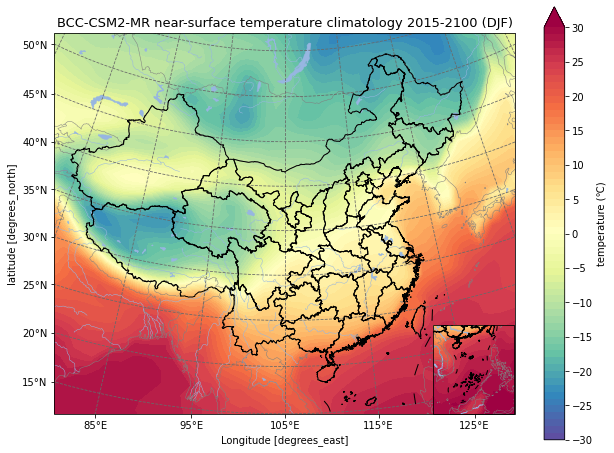

In [8]:
plot_ta_climatology('/badc/cmip6/data/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp370/r1i1p1f1/Amon/tas/gn/v20190314/tas_Amon_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_201501-210012.nc', 'DJF')
plt.savefig('BCC hist tas climatology 1850-2015 (DJF).png', dpi = 300)
plt.show()